<a href="https://colab.research.google.com/github/salsair/UAS_Kelompok-3/blob/main/UAS_Kelompok_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# UAS Klasifikasi
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("UAS KLASIFIKASI - COMPLETE PIPELINE")
print("="*60)

from google.colab import files
uploaded = files.upload()


UAS KLASIFIKASI - COMPLETE PIPELINE


Saving BlaBla.xlsx to BlaBla.xlsx


In [ ]:
# ==========================================
# 1. MEMBACA DATA
# ==========================================
print("\n1. MEMBACA DATA")
print("-" * 20)

# Load dataset

data = pd.read_excel('BlaBla.xlsx')
print(data)

# Menampilkan informasi awal tentang dataset
print("\nInfo Dataset:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

# Memisahkan fitur dan target
feature_cols = ['UMUR_TAHUN', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
X = data[feature_cols]
y = data['N']

print(f"\nVariabel Input: {feature_cols}")
print(f"Variabel Output: N")
print(f"Distribusi target variable:")
print(y.value_counts())


1. MEMBACA DATA
--------------------
      A UMUR_TAHUN  B  C  D  E  F  G  H  I  J  K  L  M  N
0     1         17  0  1  0  0  0  0  0  1  0  0  0  1  0
1     5         70  0  0  0  0  0  0  0  1  1  1  0  1  1
2     3         39  0  0  0  0  0  1  0  0  0  0  0  1  0
3     5         63  0  0  0  0  0  0  0  0  1  0  0  1  0
4     3         40  0  0  0  0  0  1  0  0  0  1  0  1  0
...  ..        ... .. .. .. .. .. .. .. .. .. .. .. .. ..
2303  2         26  0  0  1  0  0  0  1  0  1  1  1  1  1
2304  1          9  1  0  1  0  0  0  0  1  0  0  0  1  1
2305  1         19  0  0  1  0  0  0  0  0  1  1  1  1  1
2306  4         42  0  0  0  0  0  0  0  1  0  1  1  1  1
2307  1         15  0  0  0  0  0  0  1  0  0  1  0  1  1

[2308 rows x 15 columns]

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308 entries, 0 to 2307
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   A           2308 non-null   int64


2. PREPROCESSING DATA

2a1. CEK MISSING VALUE
-------------------------
Missing values per column:
A             0
UMUR_TAHUN    0
B             0
C             0
D             0
E             0
F             0
G             0
H             0
I             0
J             0
K             0
L             0
M             0
N             0
dtype: int64
Tidak ada missing values

2a2. CEK OUTLIER DAN HANDLING
------------------------------
Deteksi outlier untuk kolom numerikal:
A: 0 outliers
B: 372 outliers
C: 39 outliers
D: 337 outliers
E: 85 outliers
F: 250 outliers
G: 195 outliers
H: 175 outliers
I: 0 outliers
J: 297 outliers
K: 0 outliers
L: 151 outliers
M: 0 outliers


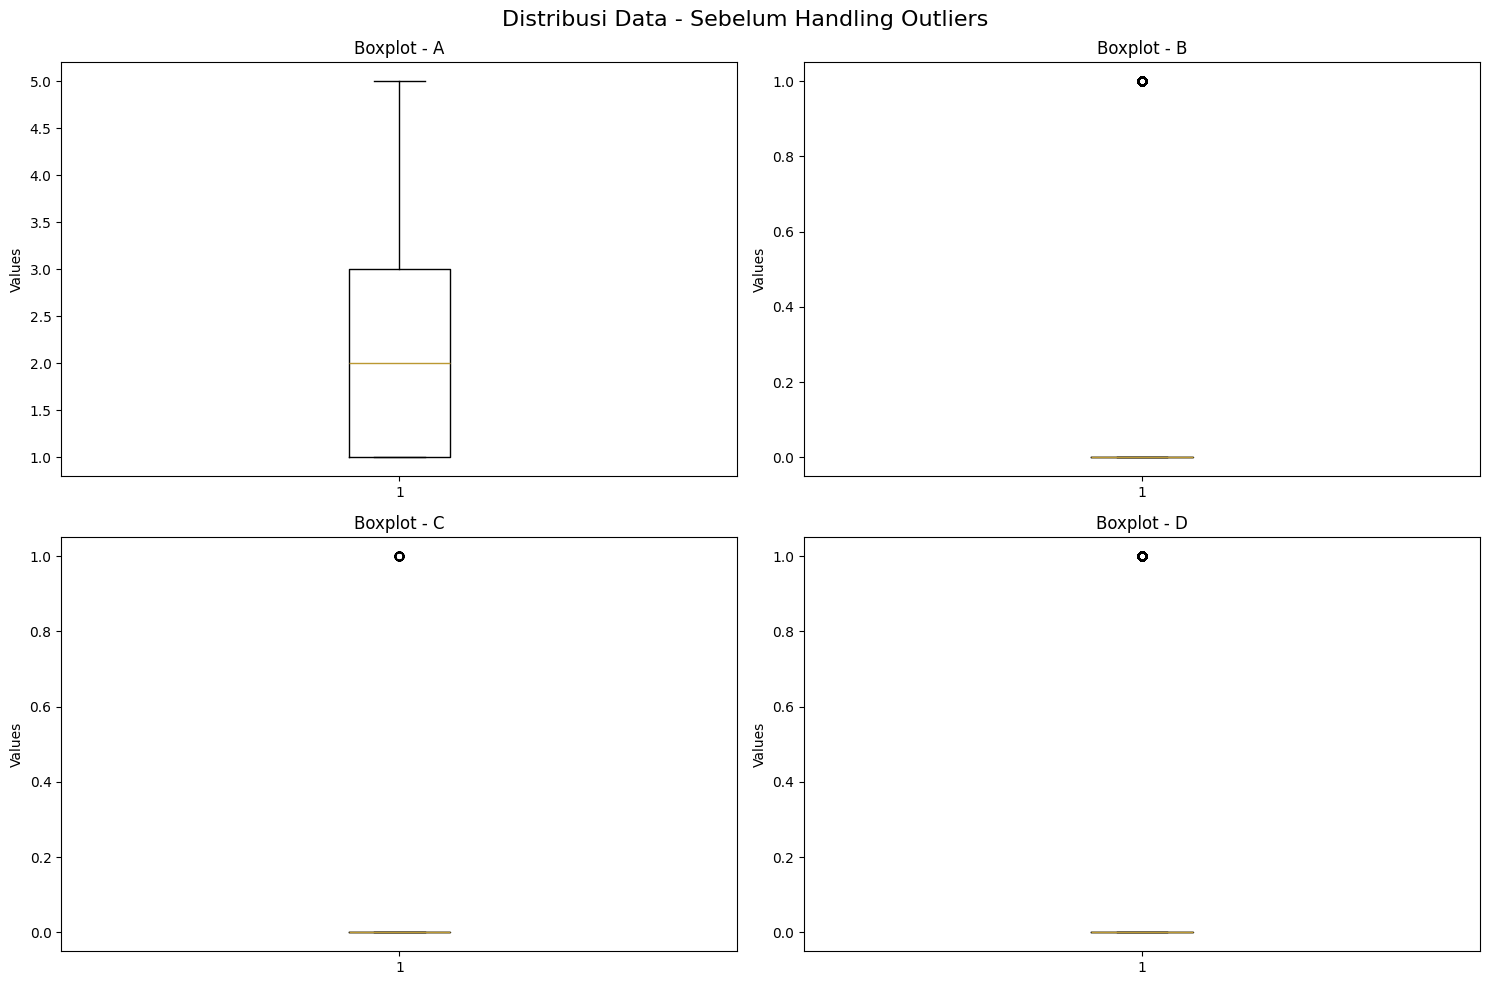


✓ 1901 outliers handled menggunakan capping method


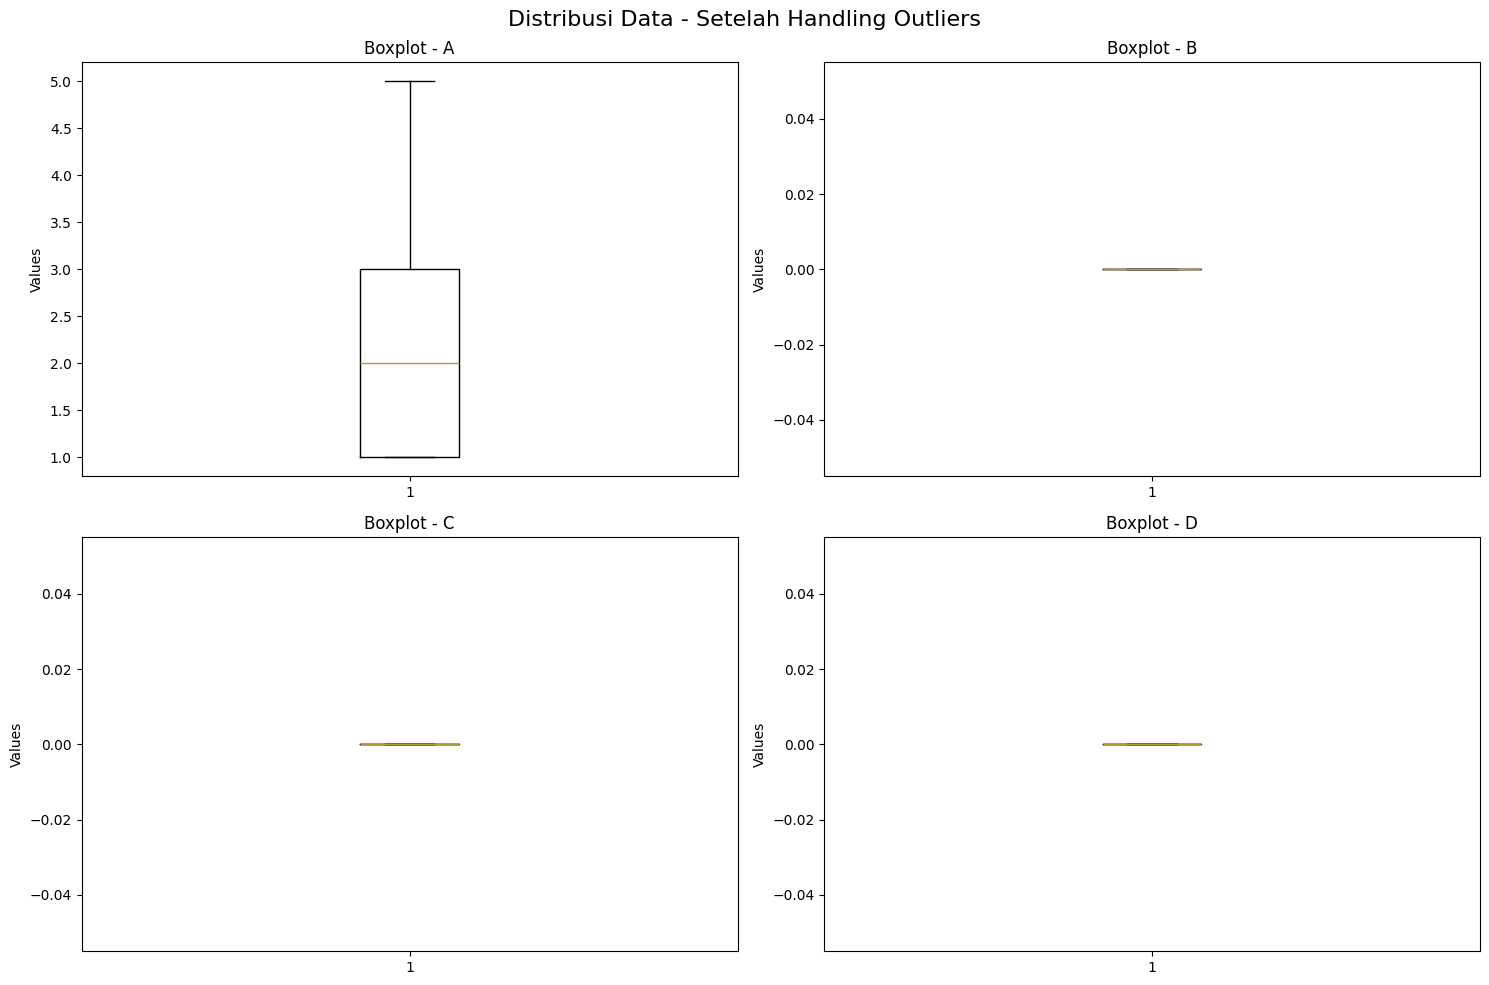


2b. ENCODING UMUR
---------------
Encoding rules:
1 = ≤ 20
2 = ≥ 21 and ≤ 30
3 = ≥ 31 and ≤ 40
4 = ≥ 41 and ≤ 50
5 = > 50

Distribusi UMUR_TAHUN:
UMUR_TAHUN
0     10
1      6
2     11
3      9
4     16
      ..
74     1
76     1
77     1
78     1
80     1
Name: count, Length: 78, dtype: int64


In [ ]:
# ==========================================
# 2. PREPROCESSING DATA
# ==========================================
print("\n" + "="*60)
print("2. PREPROCESSING DATA")
print("="*60)

# 2a1. Cek Missing Value
print("\n2a1. CEK MISSING VALUE")
print("-" * 25)
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

if missing_values.sum() > 0:
    print("\n Handling missing values...")
    # Handle missing values
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            if data[col].dtype == 'object':
                data[col].fillna(data[col].mode()[0], inplace=True)
            else:
                data[col].fillna(data[col].median(), inplace=True)
    print("Missing values handled")
else:
    print("Tidak ada missing values")

# 2a2. Cek Outlier dan Handling
print("\n2a2. CEK OUTLIER DAN HANDLING")
print("-" * 30)

# Deteksi outlier menggunakan IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Cek outlier untuk kolom numerik
numerical_cols = data.select_dtypes(include=[np.number]).columns
outlier_summary = {}

print("Deteksi outlier untuk kolom numerikal:")
for col in numerical_cols:
    if col != 'N':
        outliers, lower, upper = detect_outliers_iqr(data, col)
        outlier_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers")

# Visualisasi sebelum handling outliers
if len(numerical_cols) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Distribusi Data - Sebelum Handling Outliers', fontsize=16)

    cols_to_plot = [col for col in numerical_cols if col != 'N'][:4]

    for i, col in enumerate(cols_to_plot):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].boxplot(data[col])
        axes[row, col_idx].set_title(f'Boxplot - {col}')
        axes[row, col_idx].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

# Handle outliers menggunakan IQR
data_cleaned = data.copy()
outliers_handled = 0

for col in numerical_cols:
    if col != 'N' and outlier_summary.get(col, 0) > 0:
        outliers, lower_bound, upper_bound = detect_outliers_iqr(data_cleaned, col)

        data_cleaned[col] = np.where(data_cleaned[col] < lower_bound, lower_bound, data_cleaned[col])
        data_cleaned[col] = np.where(data_cleaned[col] > upper_bound, upper_bound, data_cleaned[col])
        outliers_handled += len(outliers)

print(f"\n✓ {outliers_handled} outliers handled menggunakan capping method")

# Visualisasi setelah handling outliers
if len(numerical_cols) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Distribusi Data - Setelah Handling Outliers', fontsize=16)

    for i, col in enumerate(cols_to_plot):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].boxplot(data_cleaned[col])
        axes[row, col_idx].set_title(f'Boxplot - {col}')
        axes[row, col_idx].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

# 2b. Encoding UMUR
print("\n2b. ENCODING UMUR")
print("-" * 15)
print("Encoding rules:")
print("1 = ≤ 20")
print("2 = ≥ 21 and ≤ 30")
print("3 = ≥ 31 and ≤ 40")
print("4 = ≥ 41 and ≤ 50")
print("5 = > 50")

data_cleaned['UMUR_TAHUN'] = pd.to_numeric(data_cleaned['UMUR_TAHUN'], errors='coerce')
data_cleaned = data_cleaned.dropna(subset=['UMUR_TAHUN'])
data_cleaned['UMUR_TAHUN'] = data_cleaned['UMUR_TAHUN'].astype(int)

print(f"\nDistribusi UMUR_TAHUN:")
print(data_cleaned['UMUR_TAHUN'].value_counts().sort_index())

# Perbarui features dan target after cleaning
X_cleaned = data_cleaned[feature_cols]
y_cleaned = data_cleaned['N']

In [ ]:
# ==========================================
# 3. SELEKSI FITUR - CHI-SQUARE
# ==========================================
print("\n" + "="*60)
print("3. SELEKSI FITUR - CHI-SQUARE")
print("="*60)

# Seleksi fitur menggunakan Chi-Square
chi2_selector = SelectKBest(chi2, k='all')
X_chi2 = chi2_selector.fit_transform(X_cleaned, y_cleaned)

# Feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Chi2_Score': chi2_selector.scores_,
    'P_Value': chi2_selector.pvalues_
}).sort_values('Chi2_Score', ascending=False)

print("Chi-square scores:")
print(feature_scores)

# Memilih top features (contoh: top 10)
top_k = min(10, len(feature_cols))
selected_features = feature_scores.head(top_k)['Feature'].tolist()
X_selected = X_cleaned[selected_features]

print(f"\nTop {top_k} selected features:")
print(selected_features)


3. SELEKSI FITUR - CHI-SQUARE
Chi-square scores:
       Feature  Chi2_Score        P_Value
10           K  584.268694  4.421388e-129
8            I  433.692831   2.553593e-96
0   UMUR_TAHUN   66.761231   3.064665e-16
12           M    0.000000   1.000000e+00
1            B         NaN            NaN
2            C         NaN            NaN
3            D         NaN            NaN
4            E         NaN            NaN
5            F         NaN            NaN
6            G         NaN            NaN
7            H         NaN            NaN
9            J         NaN            NaN
11           L         NaN            NaN

Top 10 selected features:
['K', 'I', 'UMUR_TAHUN', 'M', 'B', 'C', 'D', 'E', 'F', 'G']



SKENARIO 1: UNDER SAMPLING

4. IMBALANCED DATA - UNDER SAMPLING
-----------------------------------
Distribusi sebelum under sampling:
N
0    1628
1     679
Name: count, dtype: int64

Distribusi setelah under sampling:
N
0    679
1    679
Name: count, dtype: int64

5. KLASIFIKASI - SKENARIO 1
-------------------------
Training set: (1086, 10)
Testing set: (272, 10)

Training models...
Training Decision Tree...


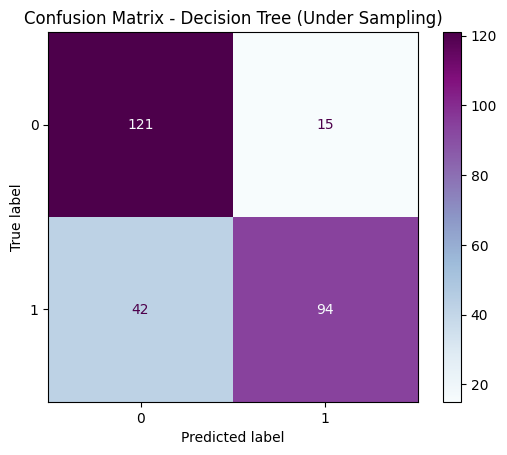

Training Random Forest...


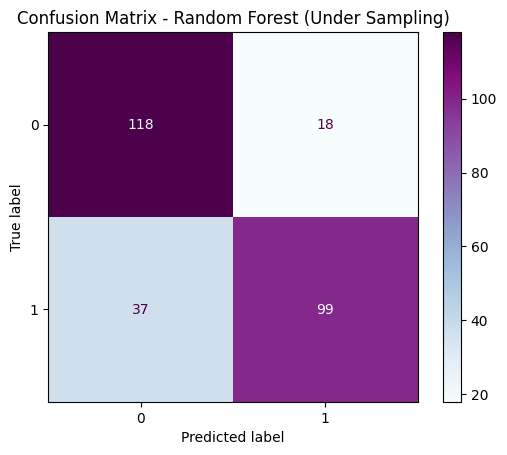

Training SVM...


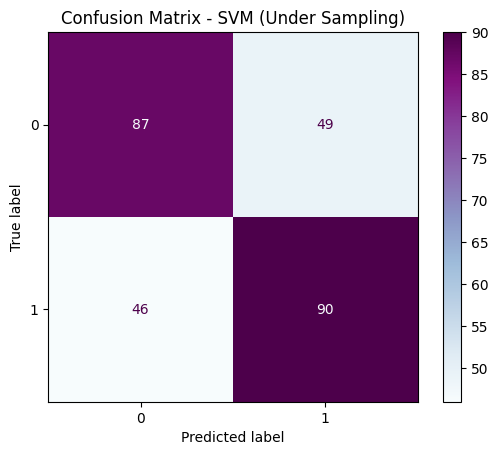

Training XGBoost...


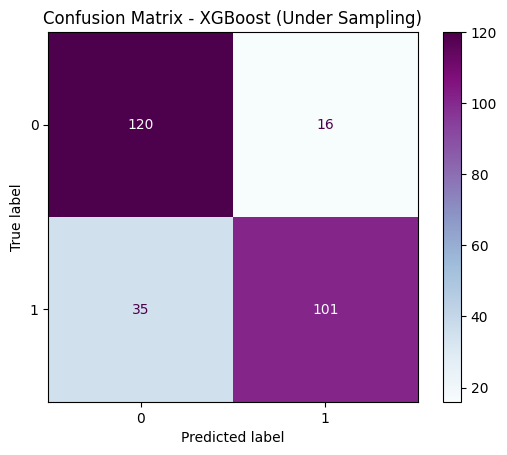

Training LightGBM...


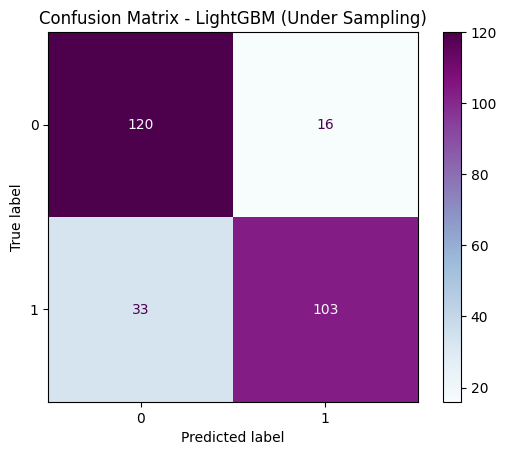


6. EVALUASI - SKENARIO 1
--------------------
Hasil evaluasi model (Skenario 1 - Under Sampling):
               Accuracy Precision    Recall  F1-Score   AUC-ROC  \
Decision Tree  0.790441  0.802358  0.790441  0.788356  0.856401   
Random Forest  0.797794  0.803722  0.797794  0.796803  0.879352   
SVM            0.650735  0.650809  0.650735  0.650693  0.768058   
XGBoost          0.8125  0.818721    0.8125  0.811581  0.890571   
LightGBM       0.819853   0.82493  0.819853  0.819146  0.895248   

                                                             FPR  \
Decision Tree  [0.0, 0.04411764705882353, 0.04411764705882353...   
Random Forest  [0.0, 0.022058823529411766, 0.0220588235294117...   
SVM            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0073529411764...   
XGBoost        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
LightGBM       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                             TPR  
Decision Tree  [0.0, 0

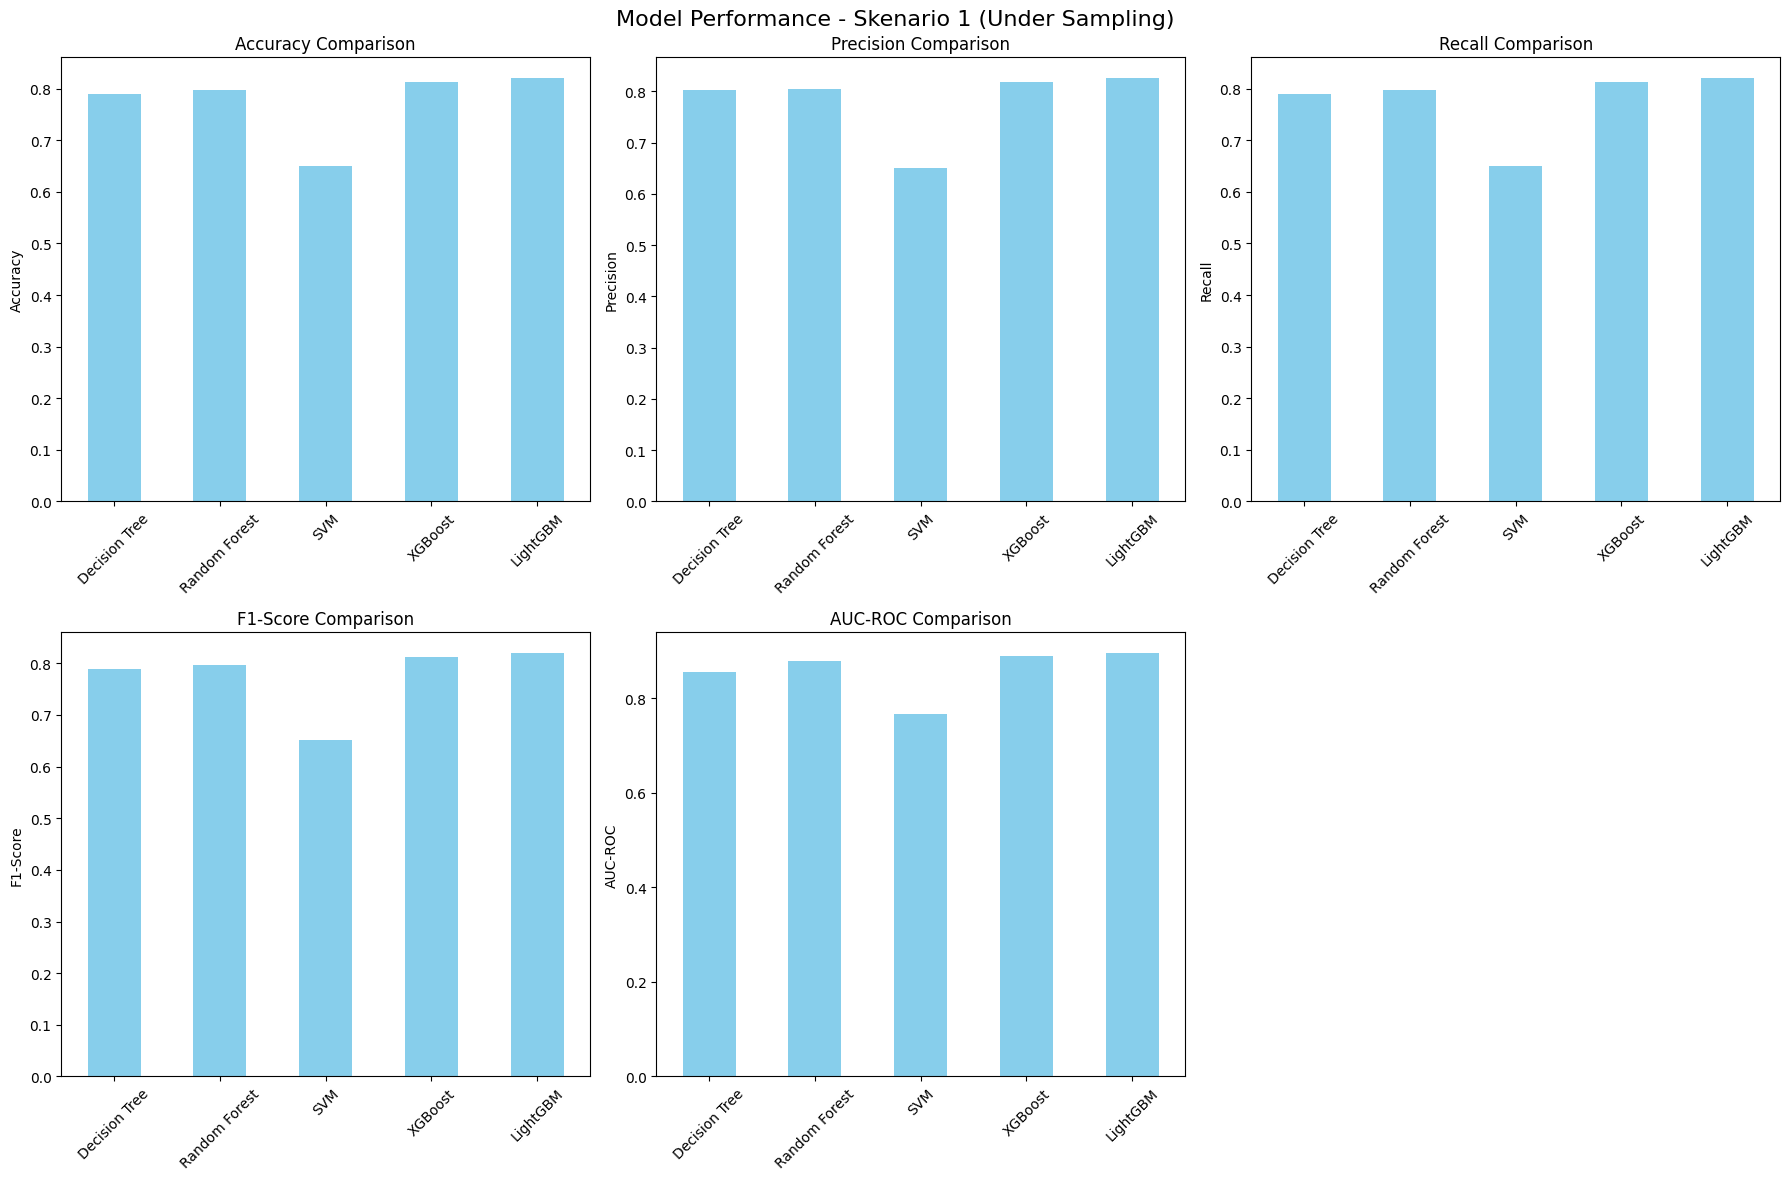

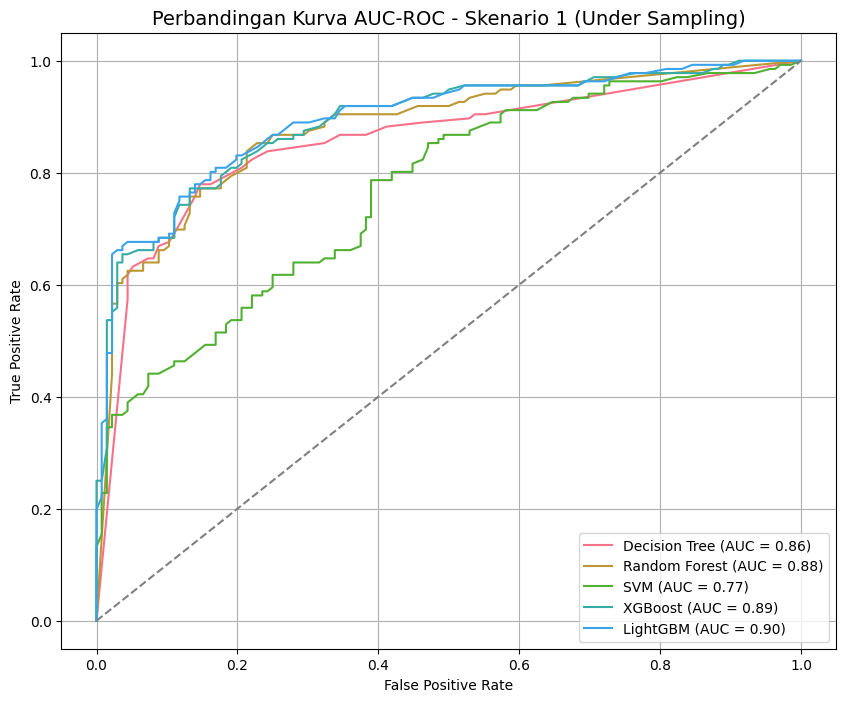

In [ ]:
# ==========================================
# SKENARIO 1: UNDER SAMPLING
# ==========================================
print("\n" + "="*60)
print("SKENARIO 1: UNDER SAMPLING")
print("="*60)

# 4. Imbalanced Data - Under Sampling
print("\n4. IMBALANCED DATA - UNDER SAMPLING")
print("-" * 35)

print("Distribusi sebelum under sampling:")
print(y_cleaned.value_counts())

under_sampler = RandomUnderSampler(random_state=42)
X_under, y_under = under_sampler.fit_resample(X_selected, y_cleaned)

print("\nDistribusi setelah under sampling:")
print(pd.Series(y_under).value_counts())

# 5. Klasifikasi - Skenario 1
print("\n5. KLASIFIKASI - SKENARIO 1")
print("-" * 25)

# Split data
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42, stratify=y_under
)

print(f"Training set: {X_train_under.shape}")
print(f"Testing set: {X_test_under.shape}")

# Inisialisasi model
models_scenario1 = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Training dan evaluasi model - Scenario 1
results_scenario1 = {}

print("\nTraining models...")
for name, model in models_scenario1.items():
    print(f"Training {name}...")

    # Training
    model.fit(X_train_under, y_train_under)

    # Prediksi
    y_pred = model.predict(X_test_under)
    y_pred_proba = model.predict_proba(X_test_under)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_test_under, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='BuPu')
    plt.title(f'Confusion Matrix - {name} (Under Sampling)')
    plt.show()

    # Menghitung Metrik
    accuracy = accuracy_score(y_test_under, y_pred)
    precision = precision_score(y_test_under, y_pred, average='weighted')
    recall = recall_score(y_test_under, y_pred, average='weighted')
    f1 = f1_score(y_test_under, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test_under, y_pred_proba)

    # ROC Curve - simpan FPR dan TPR untuk visualisasi nanti
    fpr, tpr, _ = roc_curve(y_test_under, y_pred_proba)

    results_scenario1[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'FPR': fpr,
        'TPR': tpr
    }


# 6. Evaluasi - Skenario 1
print("\n6. EVALUASI - SKENARIO 1")
print("-" * 20)

# Display hasil
results_df_scenario1 = pd.DataFrame(results_scenario1).T
print("Hasil evaluasi model (Skenario 1 - Under Sampling):")
print(results_df_scenario1.round(4))

# Visualisasi hasil
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance - Skenario 1 (Under Sampling)', fontsize=16)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    results_df_scenario1[metric].plot(kind='bar', ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Visualisasi ROC Curve
plt.figure(figsize=(10, 8))
for name, result in results_scenario1.items():
    fpr = result['FPR']
    tpr = result['TPR']
    auc = result['AUC-ROC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Perbandingan Kurva AUC-ROC - Skenario 1 (Under Sampling)', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


SKENARIO 2: OVER SAMPLING

7. IMBALANCED DATA - OVER SAMPLING
-----------------------------------
Distribusi sebelum over sampling:
N
0    1628
1     679
Name: count, dtype: int64

Distribusi setelah over sampling:
N
0    1628
1    1628
Name: count, dtype: int64

8. KLASIFIKASI - SKENARIO 2
-------------------------
Training set: (2604, 10)
Testing set: (652, 10)

Training models...
Training Decision Tree...


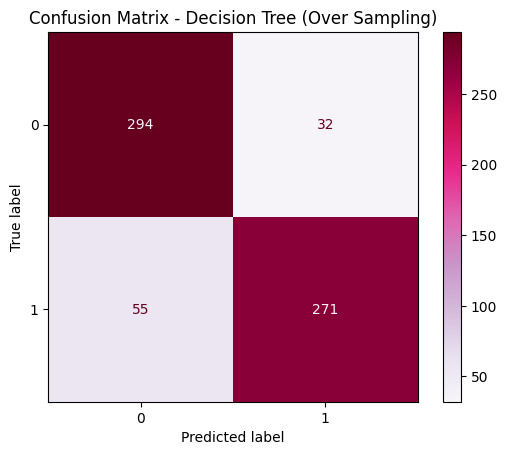

Training Random Forest...


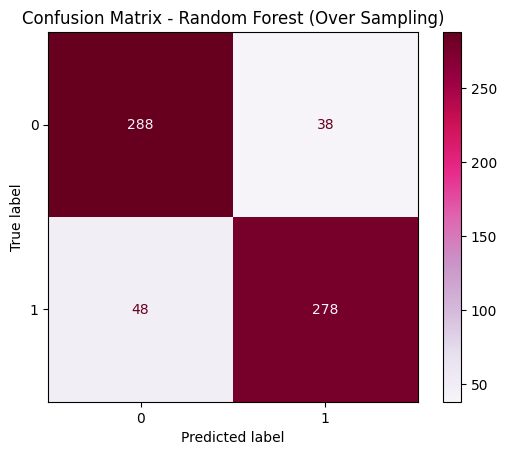

Training SVM...


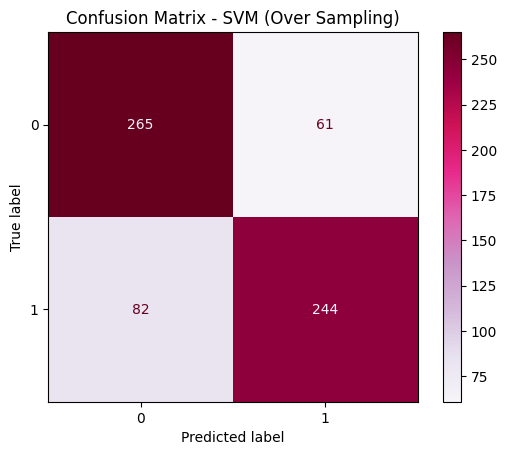

Training XGBoost...


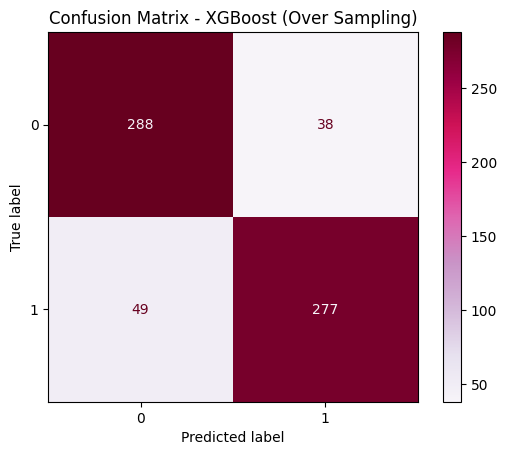

Training LightGBM...


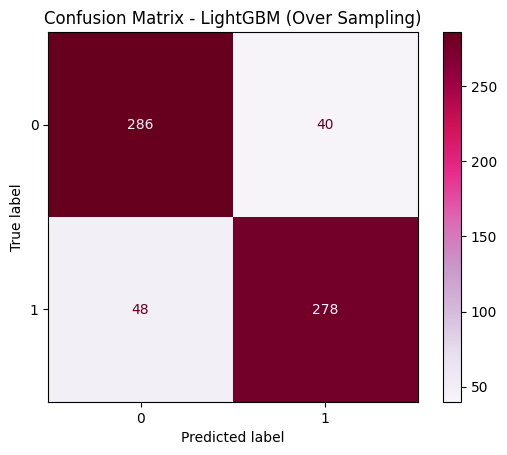


9. EVALUASI - SKENARIO 2
--------------------
Hasil evaluasi model (Skenario 2 - Over Sampling):
               Accuracy Precision    Recall  F1-Score   AUC-ROC  \
Decision Tree  0.866564  0.868398  0.866564  0.866398   0.92145   
Random Forest  0.868098  0.868445  0.868098  0.868067  0.925703   
SVM            0.780675  0.781844  0.780675  0.780447  0.897456   
XGBoost        0.866564  0.866982  0.866564  0.866526   0.93164   
LightGBM       0.865031  0.865251  0.865031   0.86501  0.932863   

                                                             FPR  \
Decision Tree  [0.0, 0.03067484662576687, 0.03374233128834356...   
Random Forest  [0.0, 0.018404907975460124, 0.0184049079754601...   
SVM            [0.0, 0.0, 0.003067484662576687, 0.00306748466...   
XGBoost        [0.0, 0.0, 0.0, 0.0, 0.003067484662576687, 0.0...   
LightGBM       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                             TPR  
Decision Tree  [0.0, 0.

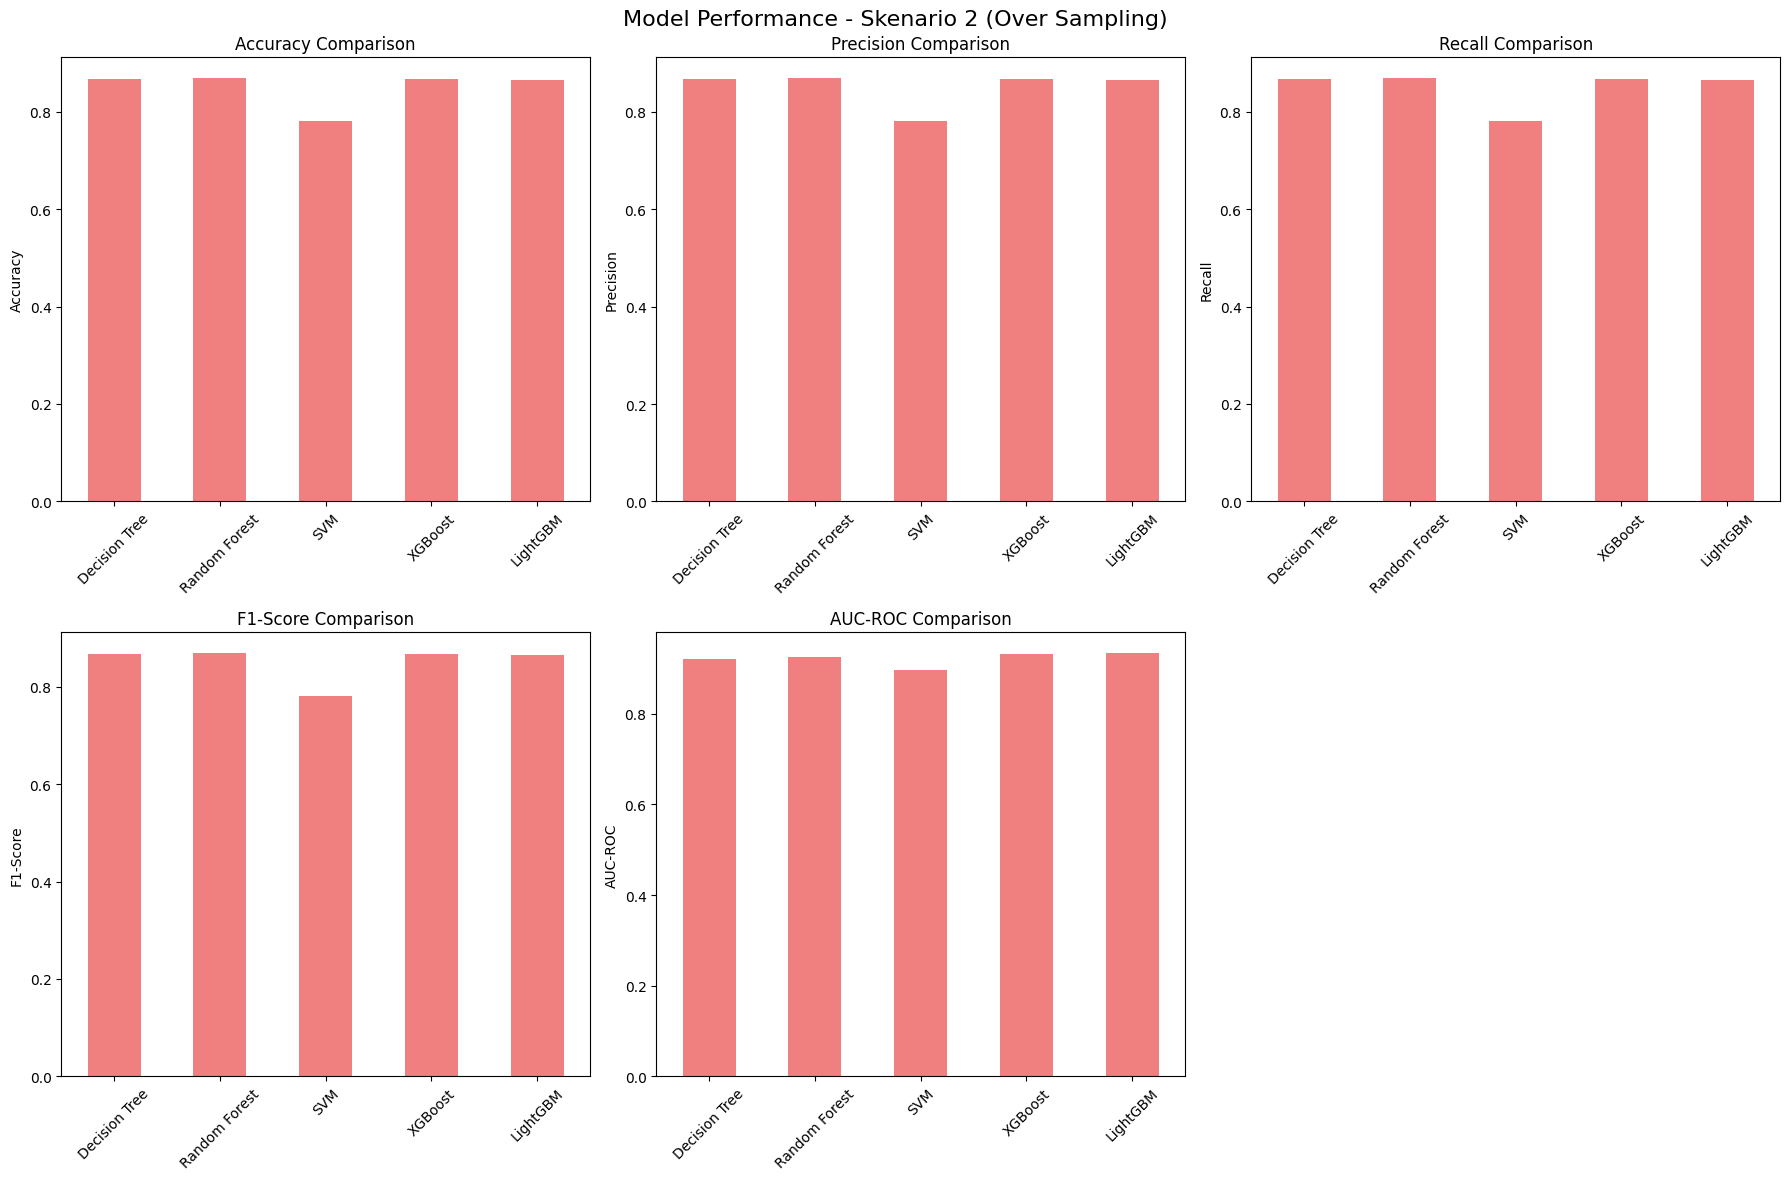

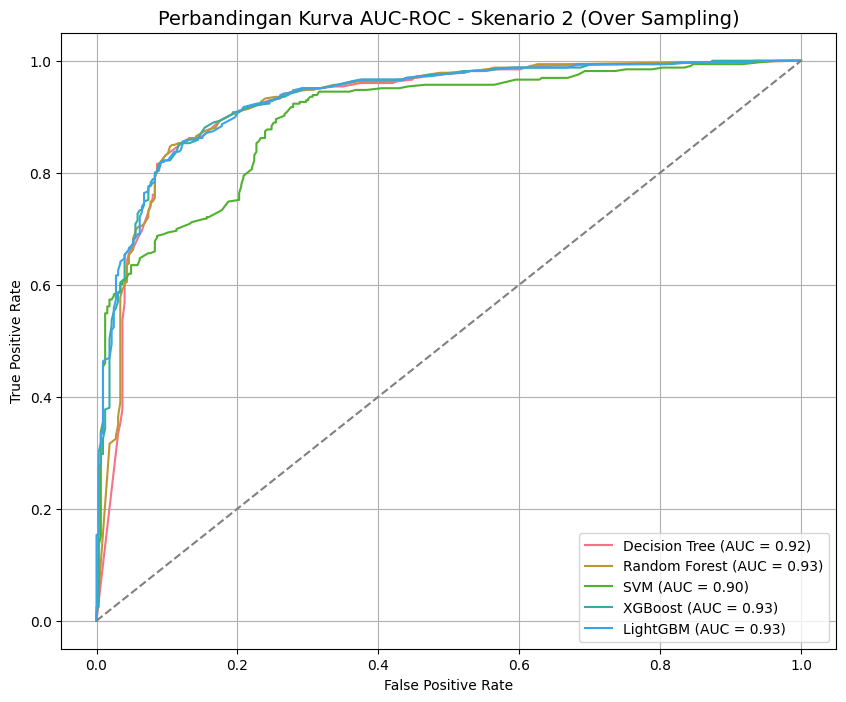

In [ ]:
# ==========================================
# SKENARIO 2: OVER SAMPLING
# ==========================================
print("\n" + "="*60)
print("SKENARIO 2: OVER SAMPLING")
print("="*60)

# 7. Imbalanced Data - Over Sampling
print("\n7. IMBALANCED DATA - OVER SAMPLING")
print("-" * 35)

print("Distribusi sebelum over sampling:")
print(y_cleaned.value_counts())

# over sampling
over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(X_selected, y_cleaned)

print("\nDistribusi setelah over sampling:")
print(pd.Series(y_over).value_counts())

# 8. Klasifikasi - Skenario 2
print("\n8. KLASIFIKASI - SKENARIO 2")
print("-" * 25)

# Split data
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over, y_over, test_size=0.2, random_state=42, stratify=y_over
)

print(f"Training set: {X_train_over.shape}")
print(f"Testing set: {X_test_over.shape}")

# Inisialisasi model
models_scenario2 = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Training and evaluasi model - Scenario 2
results_scenario2 = {}

print("\nTraining models...")
for name, model in models_scenario2.items():
    print(f"Training {name}...")

    # Training model
    model.fit(X_train_over, y_train_over)

    # Prediksi
    y_pred = model.predict(X_test_over)
    y_pred_proba = model.predict_proba(X_test_over)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_test_over, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='PuRd')
    plt.title(f'Confusion Matrix - {name} (Over Sampling)')
    plt.show()

    # Menghitung metrik
    accuracy = accuracy_score(y_test_over, y_pred)
    precision = precision_score(y_test_over, y_pred, average='weighted')
    recall = recall_score(y_test_over, y_pred, average='weighted')
    f1 = f1_score(y_test_over, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test_over, y_pred_proba)

    # ROC Curve - simpan FPR dan TPR untuk visualisasi nanti
    fpr, tpr, _ = roc_curve(y_test_over, y_pred_proba)

    results_scenario2[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'FPR': fpr,
        'TPR': tpr
    }


# 9. Evaluasi - Skenario 2
print("\n9. EVALUASI - SKENARIO 2")
print("-" * 20)

# Menampilkan hasil
results_df_scenario2 = pd.DataFrame(results_scenario2).T
print("Hasil evaluasi model (Skenario 2 - Over Sampling):")
print(results_df_scenario2.round(4))

# Visualisasi hasil
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance - Skenario 2 (Over Sampling)', fontsize=16)

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    results_df_scenario2[metric].plot(kind='bar', ax=axes[row, col], color='lightcoral')
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Visualisasi ROC Curve
plt.figure(figsize=(10, 8))
for name, result in results_scenario2.items():
    fpr = result['FPR']
    tpr = result['TPR']
    auc = result['AUC-ROC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Perbandingan Kurva AUC-ROC - Skenario 2 (Over Sampling)', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


PERBANDINGAN KEDUA SKENARIO
Perbandingan detail kedua skenario:
            Model     Metric  Scenario 1 (Under)  Scenario 2 (Over)  \
0   Decision Tree   Accuracy              0.7904             0.8666   
1   Decision Tree  Precision              0.8024             0.8684   
2   Decision Tree     Recall              0.7904             0.8666   
3   Decision Tree   F1-Score              0.7884             0.8664   
4   Decision Tree    AUC-ROC              0.8564             0.9214   
5   Random Forest   Accuracy              0.7978             0.8681   
6   Random Forest  Precision              0.8037             0.8684   
7   Random Forest     Recall              0.7978             0.8681   
8   Random Forest   F1-Score              0.7968             0.8681   
9   Random Forest    AUC-ROC              0.8794             0.9257   
10            SVM   Accuracy              0.6507             0.7807   
11            SVM  Precision              0.6508             0.7818   
12          

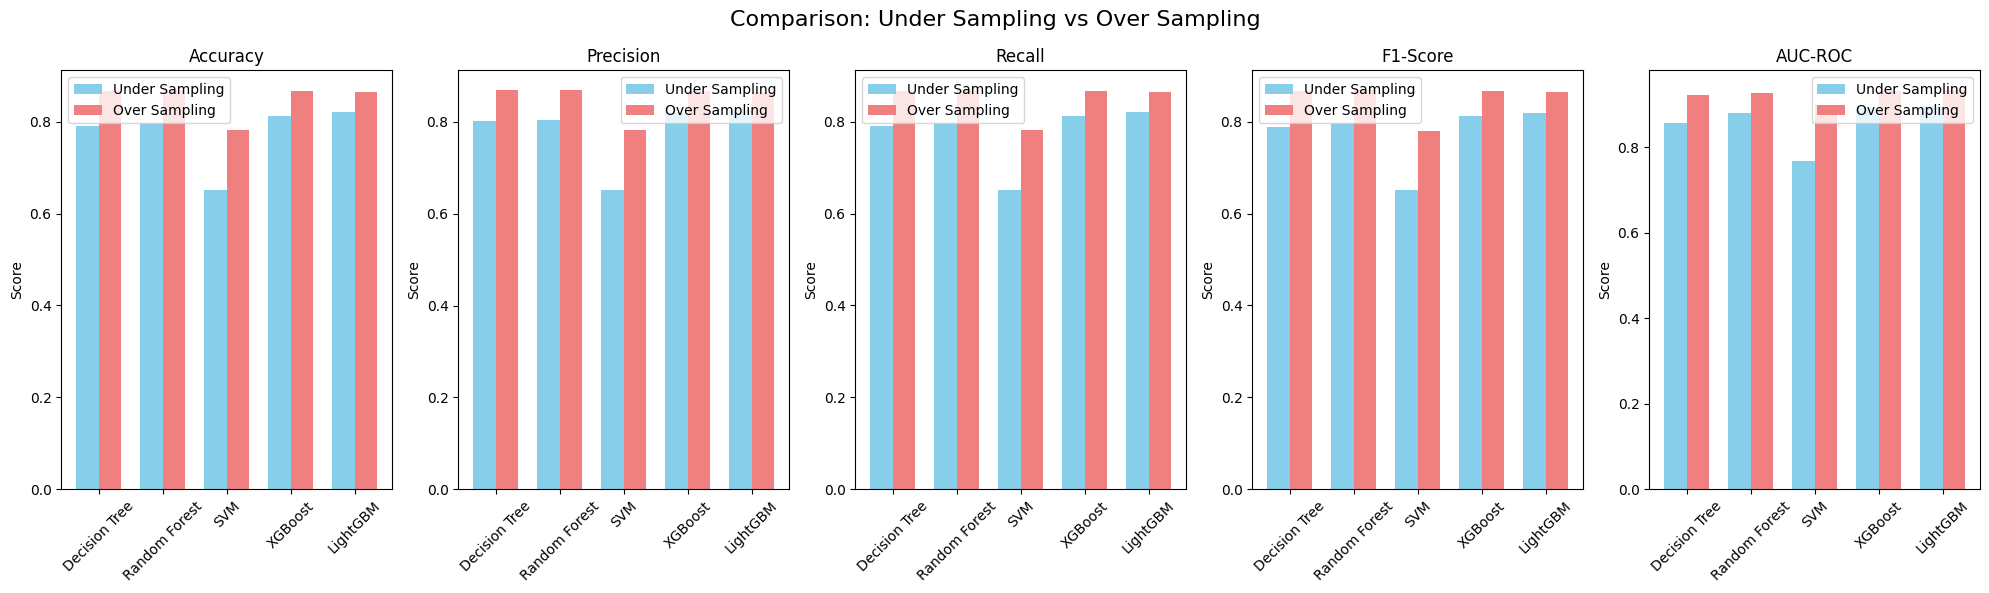


ANALISIS SELESAI!

Kesimpulan:
1. Preprocessing data telah dilakukan termasuk handling missing values dan outliers
2. Feature selection menggunakan Chi-square test telah diterapkan
3. Dua skenario imbalanced data handling telah dibandingkan:
   - Skenario 1: Under Sampling
   - Skenario 2: Over Sampling
4. Lima algoritma klasifikasi telah dievaluasi dengan berbagai metrik
5. Visualisasi perbandingan performa telah disediakan


In [ ]:
# ==========================================
# PERBANDINGAN KEDUA SKENARIO
# ==========================================
print("\n" + "="*60)
print("PERBANDINGAN KEDUA SKENARIO")
print("="*60)

# Menggabungkan kedua skenario
comparison_data = []
for model in models_scenario1.keys():
    for metric in metrics:
        comparison_data.append({
            'Model': model,
            'Metric': metric,
            'Scenario 1 (Under)': results_scenario1[model][metric],
            'Scenario 2 (Over)': results_scenario2[model][metric],
            'Difference': results_scenario2[model][metric] - results_scenario1[model][metric]
        })

comparison_df = pd.DataFrame(comparison_data)
print("Perbandingan detail kedua skenario:")
print(comparison_df.round(4))

# Ringkasan performa terbaik
print("\nRingkasan performa terbaik:")
for metric in metrics:
    best_s1 = results_df_scenario1[metric].idxmax()
    best_s1_score = results_df_scenario1.loc[best_s1, metric]

    best_s2 = results_df_scenario2[metric].idxmax()
    best_s2_score = results_df_scenario2.loc[best_s2, metric]

    print(f"{metric}:")
    print(f"  Skenario 1: {best_s1} ({best_s1_score:.4f})")
    print(f"  Skenario 2: {best_s2} ({best_s2_score:.4f})")

# Visualisasi final
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))
fig.suptitle('Comparison: Under Sampling vs Over Sampling', fontsize=16)

for i, metric in enumerate(metrics):
    scenario1_values = [results_scenario1[model][metric] for model in models_scenario1.keys()]
    scenario2_values = [results_scenario2[model][metric] for model in models_scenario2.keys()]

    x = np.arange(len(models_scenario1))
    width = 0.35

    axes[i].bar(x - width/2, scenario1_values, width, label='Under Sampling', color='skyblue')
    axes[i].bar(x + width/2, scenario2_values, width, label='Over Sampling', color='lightcoral')

    axes[i].set_title(metric)
    axes[i].set_ylabel('Score')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(models_scenario1.keys(), rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALISIS SELESAI!")
print("="*60)
print("\nKesimpulan:")
print("1. Preprocessing data telah dilakukan termasuk handling missing values dan outliers")
print("2. Feature selection menggunakan Chi-square test telah diterapkan")
print("3. Dua skenario imbalanced data handling telah dibandingkan:")
print("   - Skenario 1: Under Sampling")
print("   - Skenario 2: Over Sampling")
print("4. Lima algoritma klasifikasi telah dievaluasi dengan berbagai metrik")
print("5. Visualisasi perbandingan performa telah disediakan")